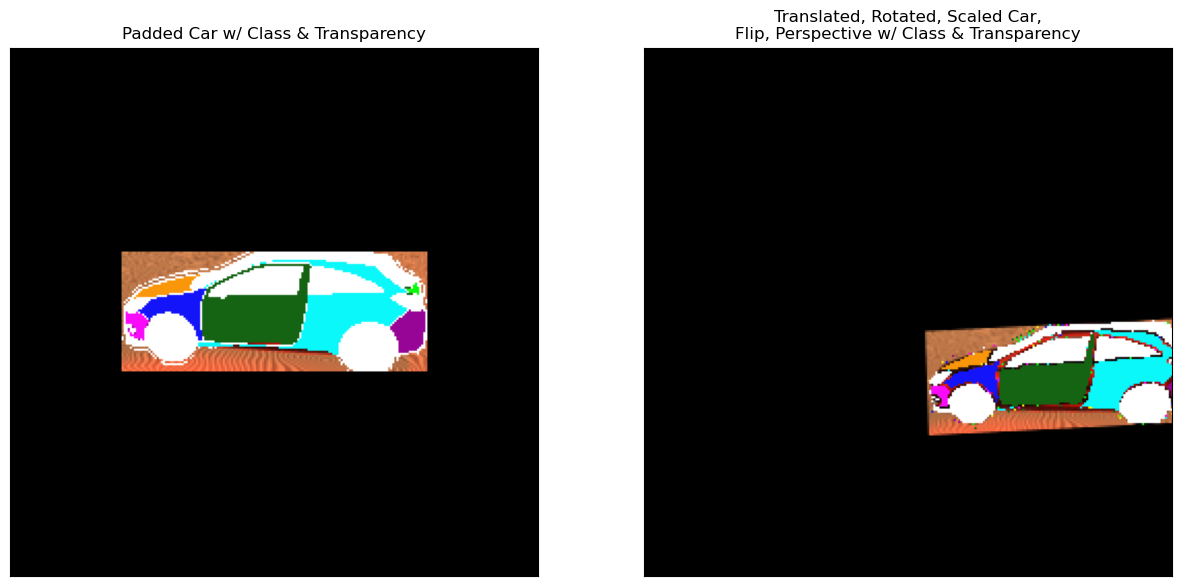

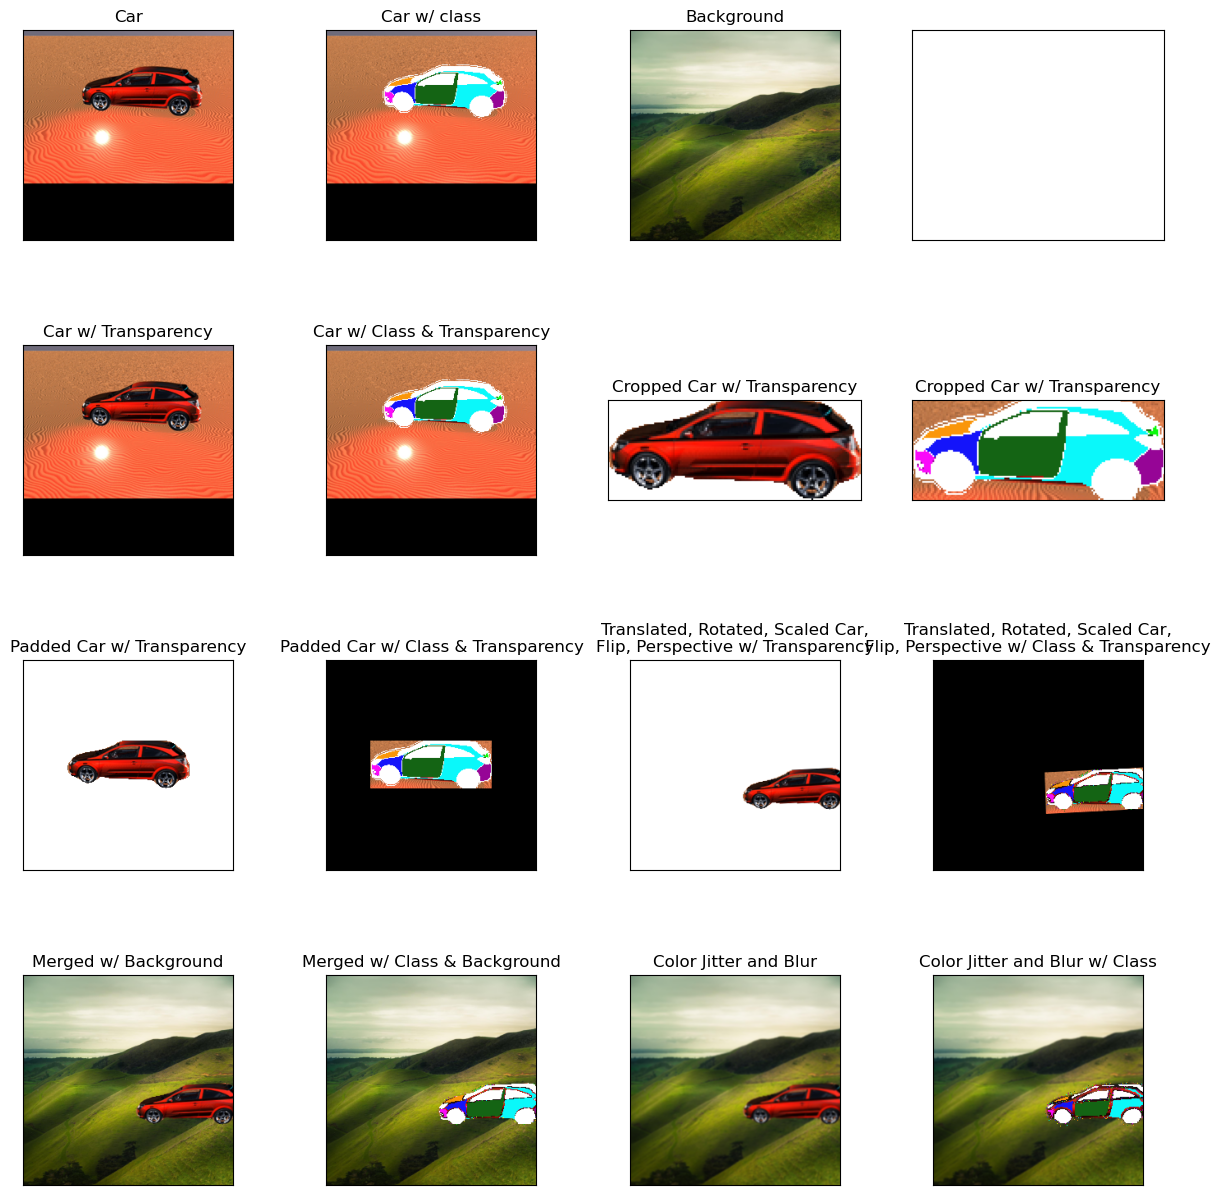

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize

import augment_data

# Global constants
IMAGE_SIZE = 256
# Parameters for affine_transform()
MAX_CROP_MARGIN = 0  # ∈ [0,1]. Indicates how much of the car can be cropped off when doing a random translation in affine_transform(). It is still possible that more is cropped off, e.g. when the car gets moved in a corner, gets rotated, or in the scaling step.
MAX_DEGREE = 12  # ∈ [0,∞]. Indicates how much the car may get rotated. Random sample from [-MAX_DEGREE,MAX_DEGREE].
SCALING = (0.8, 1.2)  # ∈ [0,∞]². Indicates how much the car may get scaled. Random sample from [min,max].


def plot_image(pos, img_array, title=""):
    axes.ravel()[pos].imshow(img_array)
    axes.ravel()[pos].set_title(title)



if __name__ == '__main__':
    # Load car image
    img_path = '../carseg_data/arrays_v2/orange_3_doors_0001.npy'
    img_array = np.load(img_path)

    # Load car mask determined by detectron2
    mask_path = '../carseg_data/arrays_car_masks/orange_3_doors_0001.npy'
    mask_array = np.load(mask_path)
    
    # Load background image and scale it to 256×256
    bimg_path = '../carseg_data/images/landscapes/0001.jpg'
    bimg_array = augment_data.load_background(bimg_path)
    
    
    # Processing
    
    # 1: Take car image and add transparency information channel
    img_array = augment_data.add_transparency_channel(img_array)
    bimg_array = augment_data.add_transparency_channel(bimg_array)
    img_array_with_class = augment_data.color_classes(img_array)
    # 2: Make background transparent
    img_array_transparent_background = augment_data.make_background_transparent(img_array, mask_array=mask_array)
    # 3: Move car to center; 3.1: Crop to smallest rectangle still containing the car
    img_array_cropped = augment_data.crop_image(img_array_transparent_background)
    img_array_cropped_with_class = augment_data.color_classes(img_array_cropped)
    # 3: Move car to center; 3.2: Place it in the middle of a transparent 256×256 image
    car_shape = img_array_cropped.shape[:2]
    img_array_padded = augment_data.pad_image(img_array_cropped)
    img_array_padded_with_class = augment_data.color_classes(img_array_padded)
    # 4: Do affine transformations, i.e., rotate, translate, scale, flip, and perspective change.
    translation = augment_data.calc_translation(car_shape)
    img_array_affine = augment_data.affine_transform(img_array_padded, translate=translation)
    img_array_affine_with_class = augment_data.color_classes(img_array_affine)
    # 5: Place car image on top of the background image
    img_array_with_background = augment_data.place_foreground_on_background_pic(img_array_affine, bimg_array)
    img_array_with_background_with_class = augment_data.color_classes(img_array_with_background)
    # 6: Remove transparency information from picture
    img_array_with_background = augment_data.remove_transparency_channel(img_array_with_background)
    # 7: Do color jittering, blur
    img_array_postprocessed = augment_data.postprocessing(img_array_with_background)
    img_array_postprocessed_with_class = augment_data.color_classes(img_array_postprocessed)
    
    # Temp plotting
    fig2, axes2 = plt.subplots(1, 2, figsize=(15, 15))
    axes2.ravel()[0].imshow(img_array_padded_with_class[:, :, :4])
    axes2.ravel()[0].set_title('Padded Car w/ Class & Transparency')
    axes2.ravel()[0].tick_params(left = False, right = False , labelleft = False , 
                labelbottom = False, bottom = False) 
    axes2.ravel()[1].imshow(img_array_affine_with_class[:, :, :4])
    axes2.ravel()[1].set_title('Translated, Rotated, Scaled Car,\nFlip, Perspective w/ Class & Transparency')
    axes2.ravel()[1].tick_params(left = False, right = False , labelleft = False , 
                labelbottom = False, bottom = False) 
    plt.show()
    
    # Set up Plotting
    n_rows = 4
    n_cols = 4
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 15))
    fig.subplots_adjust(hspace=0.5)
    
    # Plotting
    plot_image(0, img_array[:, :, :3], 'Car')
    plot_image(1, img_array_with_class[:, :, :3], 'Car w/ class')
    plot_image(2, bimg_array, 'Background')
    
    plot_image(4, img_array[:, :, :4], 'Car w/ Transparency')
    plot_image(5, img_array_with_class[:, :, :4], 'Car w/ Class & Transparency')
    plot_image(6, img_array_cropped[:, :, :4], 'Cropped Car w/ Transparency')
    plot_image(7, img_array_cropped_with_class[:, :, :4], 'Cropped Car w/ Transparency')
    plot_image(8, img_array_padded[:, :, :4], 'Padded Car w/ Transparency')
    plot_image(9, img_array_padded_with_class[:, :, :4], 'Padded Car w/ Class & Transparency')
    plot_image(10, img_array_affine[:, :, :4], 'Translated, Rotated, Scaled Car,\nFlip, Perspective w/ Transparency')
    plot_image(11, img_array_affine_with_class[:, :, :4], 'Translated, Rotated, Scaled Car,\nFlip, Perspective w/ Class & Transparency')
    
    plot_image(12, img_array_with_background[:, :, :3], 'Merged w/ Background')
    plot_image(13, img_array_with_background_with_class[:, :, :3], 'Merged w/ Class & Background')
    plot_image(14, img_array_postprocessed[:, :, :3], 'Color Jitter and Blur')
    plot_image(15, img_array_postprocessed_with_class[:, :, :3], 'Color Jitter and Blur w/ Class')
    
    # Plotting: remove ticks and numbers
    for ax in axes.ravel():
        # ax.axis('off')
        ax.tick_params(left = False, right = False , labelleft = False , 
                labelbottom = False, bottom = False) 


In [2]:
# Test calc_translation() function
l = [
    {
        'car': (100, 100),
        'frame': (100, 100),
        'c': 0,
        'output': (0, 0),
    },
    {
        'car': (50, 50),
        'frame': (100, 100),
        'c': 0,
        'output': (0.25, 0.25),
    },
    {
        'car': (100, 100),
        'frame': (100, 100),
        'c': 1,
        'output': (1, 1),
    },
    {
        'car': (50, 50),
        'frame': (100, 100),
        'c': 1,
        'output': (0.75, 0.75),
    },
]
    
for d in l:
    car, frame, c, output = d.values()
    # print(f'car={car}, frame={frame}, c={c}, output={output}, ', end='')
    actual_output = calc_translation(car, frame, c)
    # print(f'actual_output={actual_output}')
    assert actual_output == output
    
print('Test successful')


NameError: name 'calc_translation' is not defined

In [ ]:
# Test make_background_transparent with mask
import numpy as np
from augment_data import make_background_transparent

a = np.zeros((3, 3, 4))
a[:, :, 1] = np.ones((3, 3))*255

mask = np.array([[True, False, False],
                  [False, True, False],
                  [False, False, True]])

b = make_background_transparent(a, criterion='mask', mask_array=mask)

print(f'{a=}')
print(f'{mask=}')
print(f'{b=}')